0.1	0.00000000	quadratic_PFL_F1_0.50,0.00_F2_0.50,0.00_M2_K10_R200_sgd0.1,0.0,0.0_seed0.csv
0.05	0.00000000	quadratic_SFL_F1_0.50,0.00_F2_0.50,0.00_M2_K10_R200_sgd0.05,0.0,0.0_seed0.csv
quadratic_F1_0.50,0.00_F2_0.50,0.00_M2_R200


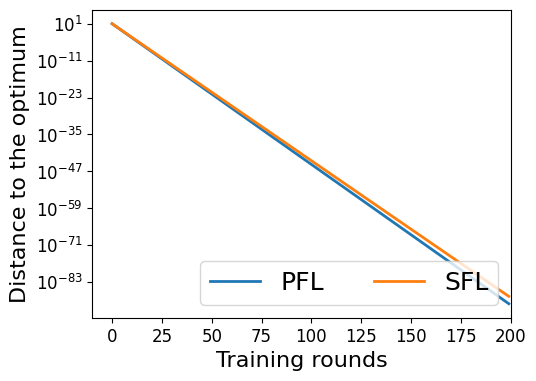

In [14]:
import sys 
sys.path.append("/home/moon/data/exps/SFL/")

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

from sim.utils.record_utils import read_fromcsv


def linear_search(pattern, lrs, K, subpath=''):
    global path, seeds, args
    
    select = 20

    for i in range(len(lrs)):
        # stack the distances over seeds
        for j in range(len(seeds)):
            source_file = pattern.format(K, lrs[i], seeds[j])
            #print(source_file)
            df = read_fromcsv(source_file, os.path.join(path, subpath))
            data = df.iloc[:, 1].values
            if j == 0:
                distances = np.array(data)
            else:
                distances = np.vstack((distances, data))
        # compare the averaged distances over multiple seeds and last `select` rounds
        if i == 0:
            distance_avg_seeds = distances.mean(axis=0)
            distance_avg_seeds_rounds = distance_avg_seeds[-select:].mean(axis=0)
            best_avg_distance = distance_avg_seeds_rounds
            best_lr = lrs[i]
        else:
            distance_avg_seeds = distances.mean(axis=0)
            distance_avg_seeds_rounds = distance_avg_seeds[-select:].mean(axis=0)
            if distance_avg_seeds_rounds <= best_avg_distance:
                best_avg_distance = distance_avg_seeds_rounds
                best_lr = lrs[i]
    print('{}\t{:.8f}\t{}'.format(best_lr, best_avg_distance, pattern.format(K, best_lr, seeds[0])))
    return best_lr
    
def plotmean(patterns, setup):
    global args, seeds, lrs  
    e = setup['end']
    y = setup['y']
    Ks = [10]

    ylabel = 'Distance to the optimum'
    xlabel = 'Training rounds'
    filename = f"quadratic_F1_{args['F1'][0]},{args['F1'][1]}_F2_{args['F2'][0]},{args['F2'][1]}_M{args['M']}_R{args['R']}"
    
    PFLdata, PFLlegend = [], []
    for k_id in range(len(Ks)):
        best_lr = linear_search(patterns[0], lrs, Ks[k_id])
        for seed_id in range(len(seeds)):
            file = patterns[0].format(Ks[k_id], best_lr, seeds[seed_id])
            df = read_fromcsv(file, path)
            datat = df.iloc[:e, y].values
            if seed_id == 0:
                data = datat
            else:
                data = np.vstack((data, datat))
        PFLdata.append(data)
        #PFLlegend.append('PFL, $K$={}'.format(Ks[k_id]))
        PFLlegend.append('PFL')

    SFLdata, SFLlegend = [], []
    for k_id in range(len(Ks)):
        best_lr = linear_search(patterns[1], [t/2 for t in lrs], Ks[k_id])
        for seed_id in range(len(seeds)):
            file = patterns[1].format(Ks[k_id], best_lr, seeds[seed_id])
            df = read_fromcsv(file, path)
            datat = df.iloc[:e, y].values
            if seed_id == 0:
                data = datat
            else:
                data = np.vstack((data, datat))
        SFLdata.append(data)
        #SFLlegend.append('SFL, $K$={}'.format(Ks[k_id]))
        SFLlegend.append('SFL')
    
    fig = plt.figure(figsize=(5.4, 4)) # 5,4
    x_axis = list(range(0, e))
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
    for i in range(len(Ks)):
        plt.plot(x_axis, PFLdata[i].mean(axis=0), linestyle='solid', color=colors[0], lw=2, label=PFLlegend[i])
        #plt.fill_between(x_axis, FedAvgdata[i].mean(axis=0) - FedAvgdata[i].std(axis=0), FedAvgdata[i].mean(axis=0) +FedAvgdata[i].std(axis=0), facecolor=colors[i], alpha=0.25) 
        plt.fill_between(x_axis, PFLdata[i].min(axis=0), PFLdata[i].max(axis=0), facecolor=colors[0], alpha=0.25) 

    for i in range(len(Ks)):
        plt.plot(x_axis, SFLdata[i].mean(axis=0), linestyle='solid', color=colors[1], lw=2, label=SFLlegend[i])
        #plt.fill_between(x_axis, SSLdata[i].mean(axis=0) - SSLdata[i].std(axis=0), SSLdata[i].mean(axis=0) + SSLdata[i].std(axis=0), facecolor=colors[i], alpha=0.25) 
        plt.fill_between(x_axis, SFLdata[i].min(axis=0), SFLdata[i].max(axis=0), facecolor=colors[1], alpha=0.25) 

    #plt.title(plotname, fontsize=20)        
    plt.ylabel(ylabel, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    #plt.ylim(ymin=0, ymax=2.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.yscale('log')
    #plt.xlim(xmin=-1, xmax=10) # for indentical data
    plt.xlim(xmin=None, xmax=args['R']) # for general heterogeneous data
    #plt.ylim(ymin=0.0001, ymax=10)
    #plt.ylim(ymin=0.1, ymax=10)
    #plt.legend([line1, line2, line3], lines, loc=None, ncol= 1, prop={'size': 14}) # loc = 1 or 4
    #if args['F1'][1] == '100.00':
    plt.legend(loc=4, ncol= 2, prop={'size': 18}) # apx
    #plt.legend(loc=1, ncol= 1, prop={'size': 18}) # main body
    #plt.minorticks_on()
    #plt.grid(which='minor', ls=':', axis='both', alpha=0.6)
    print(filename)
    #plt.savefig('../figs/{}.png'.format(filename), bbox_inches='tight', dpi=300)


def main():
    global path, lrs, seeds, args
    path = f"/home/moon/data/exps/sequential_local_sgd/save/quadratic/"
    seeds = [0,1,2,3,4,5,6,7,8,9]
    lrs = [0.0001, 0.001, 0.01, 0.1]

    args = {'F1':['0.50', '0.00'], 'F2':['0.50', '0.00'], 'M': 2, 'R': 200, 'K': None, 'seed': None}
    #args = {'F1':['0.50', '10.00'], 'F2':['0.50', '-10.00'], 'M': 2, 'R': 200, 'K': None, 'seed': None}
    #args = {'F1':['0.75', '1.00'], 'F2':['0.25', '-1.00'], 'M': 2, 'R': 200, 'K': None, 'seed': None}
    #args = {'F1':['1.00', '1.00'], 'F2':['0.00', '-1.00'], 'M': 2, 'R': 200, 'K': None, 'seed': None}
    args['L'] = 0.0

    pattern1 = f"quadratic_PFL_F1_{args['F1'][0]},{args['F1'][1]}_F2_{args['F2'][0]},{args['F2'][1]}_M{args['M']}_K{{}}_R{args['R']}_sgd{{}},0.0,0.0_seed{{}}.csv"
    pattern2 = f"quadratic_SFL_F1_{args['F1'][0]},{args['F1'][1]}_F2_{args['F2'][0]},{args['F2'][1]}_M{args['M']}_K{{}}_R{args['R']}_sgd{{}},0.0,0.0_seed{{}}.csv"

    #pattern1 = f"quadraticII{args['L']}_PFL_F1_{args['F1'][0]},{args['F1'][1]}_F2_{args['F2'][0]},{args['F2'][1]}_M{args['M']}_K{{}}_R{args['R']}_sgd{{}},0.0,0.0_seed{{}}.csv"
    #pattern2 = f"quadraticII{args['L']}_SFL_F1_{args['F1'][0]},{args['F1'][1]}_F2_{args['F2'][0]},{args['F2'][1]}_M{args['M']}_K{{}}_R{args['R']}_sgd{{}},0.0,0.0_seed{{}}.csv"

    plotmean(patterns = [pattern1, pattern2], setup={'start': 1, 'end': 200, 'y': 1, 'step': 1, 'compute': 0, 'select': 20})
    #linear_search(pattern1, K=2)
    #linear_search(pattern2, K=2)

if __name__ == '__main__':
    main()
